In [1]:
import pandas as pd
# Load the data
file_path = '/Users/duii/Desktop/crime_prevention_analysis/datasets/UK_Police_Street_Crime_2018-10-01_to_2021_09_31.csv'
df = pd.read_csv(file_path)

# Display the first few rows to understand its structure
df.head()
# Cleaning the data
# 1. Filter out rows with missing or invalid location data
df_cleaned = df.dropna(subset=['Longitude', 'Latitude'])

df_cleaned = df_cleaned[df_cleaned['Crime type'] == "Violence and sexual offences"]
df_cleaned
# 2. Drop columns that may not be necessary for our geographical and crime type analysis
columns_to_keep = ['Month', 'Longitude', 'Latitude']
df_cleaned = df_cleaned[columns_to_keep]
df_cleaned

,Month,Longitude,Latitude
9,2020-01,-1.882746,53.933807
17,2020-01,-1.819597,53.923411
18,2020-01,-1.819121,53.920696
54,2020-01,-1.822354,53.926776
55,2020-01,-1.820732,53.925147
...,...,...,...
18994548,2018-12,-2.977735,53.090924
18994556,2018-12,-2.967826,53.085234
18994559,2018-12,-2.963595,53.087615
18994560,2018-12,-2.957058,53.093798


In [2]:
data = df_cleaned.copy()

# Convert 'Month' to datetime and ensure it falls within the specified range
data['Month'] = pd.to_datetime(data['Month'])

# Define the date range
start_date = pd.to_datetime('2018-10-01')
end_date = pd.to_datetime('2021-09-30')

# Filter the dataset for the specified date range
filtered_data = data[(data['Month'] >= start_date) & (data['Month'] <= end_date)]

# Check for missing values in the dataset
missing_values = filtered_data.isnull().sum()

# Display the number of rows after filtering and the missing values
filtered_rows = filtered_data.shape[0]
missing_values, filtered_rows



(Month        0
 Longitude    0
 Latitude     0
 dtype: int64,
 5521994)

In [3]:

filtered_data
# Extract Year and Month from 'Month' column
filtered_data['Year'] = filtered_data['Month'].dt.year
filtered_data['Month'] = filtered_data['Month'].dt.month

# Display the modified dataset with new features
filtered_data.head()


,Month,Longitude,Latitude,Year
9,1,-1.882746,53.933807,2020
17,1,-1.819597,53.923411,2020
18,1,-1.819121,53.920696,2020
54,1,-1.822354,53.926776,2020
55,1,-1.820732,53.925147,2020


In [4]:
# Correctly split the dataset based on the date range for training and testing sets
correct_train_data = filtered_data[(filtered_data['Year'] < 2021)]
correct_test_data = filtered_data[(filtered_data['Year'] == 2021)]

# Summary of the correct split
correct_train_summary = (correct_train_data['Year'].min(), correct_train_data['Year'].max(), len(correct_train_data))
correct_test_summary = (correct_test_data['Year'].min(), correct_test_data['Year'].max(), len(correct_test_data))

correct_train_summary, correct_test_summary

((2018, 2020, 4097726), (2021, 2021, 1424268))

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

# Since we're transforming the task into predicting crime density/frequency,
# let's aggregate the data by Year, Month, Latitude, and Longitude to get crime counts (frequency) in those areas
agg_data = correct_train_data.groupby(['Year', 'Month', 'Latitude', 'Longitude']).size().reset_index(name='Crime_Count')

# Preparing features (X) and target (y)
X = agg_data[['Year', 'Month', 'Latitude', 'Longitude']]
y = agg_data['Crime_Count']

# Splitting the aggregated data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the GBM model
gbm_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the model
gbm_model.fit(X_train, y_train)

# Display a message when training is complete
"Model training is complete."


'Model training is complete.'

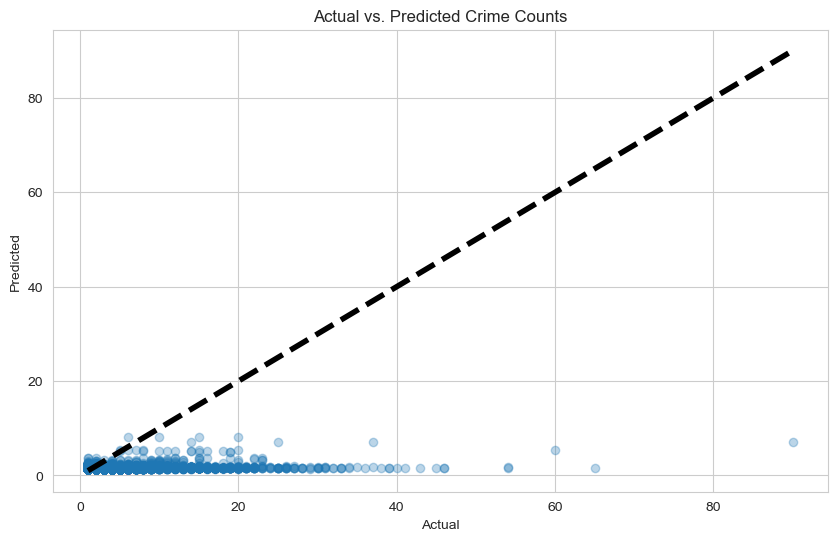

(1.2225849495039547, 0.7672778033383374)

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Predict on the validation set
y_pred = gbm_model.predict(X_val)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)

# Visualization of actual vs predicted crime counts
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Crime Counts')
plt.show()

rmse, mae


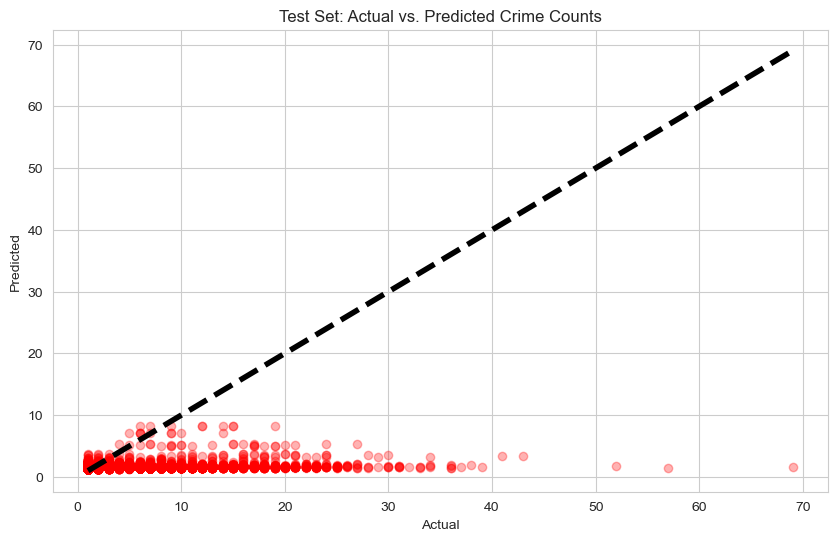

(1.2553842061065295, 0.7953912824699314)

In [7]:
# For prediction, we need to aggregate the test data similarly to the training data
test_agg_data = correct_test_data.groupby(['Year', 'Month', 'Latitude', 'Longitude']).size().reset_index(name='Crime_Count')

# Preparing features for the test set
X_test = test_agg_data[['Year', 'Month', 'Latitude', 'Longitude']]
y_test_actual = test_agg_data['Crime_Count']

# Predict on the test set
y_test_pred = gbm_model.predict(X_test)

# Calculate evaluation metrics for the test set
test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
test_mae = mean_absolute_error(y_test_actual, y_test_pred)

# Visualization of actual vs predicted crime counts on the test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, y_test_pred, alpha=0.3, color='red')
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Test Set: Actual vs. Predicted Crime Counts')
plt.show()

test_rmse, test_mae


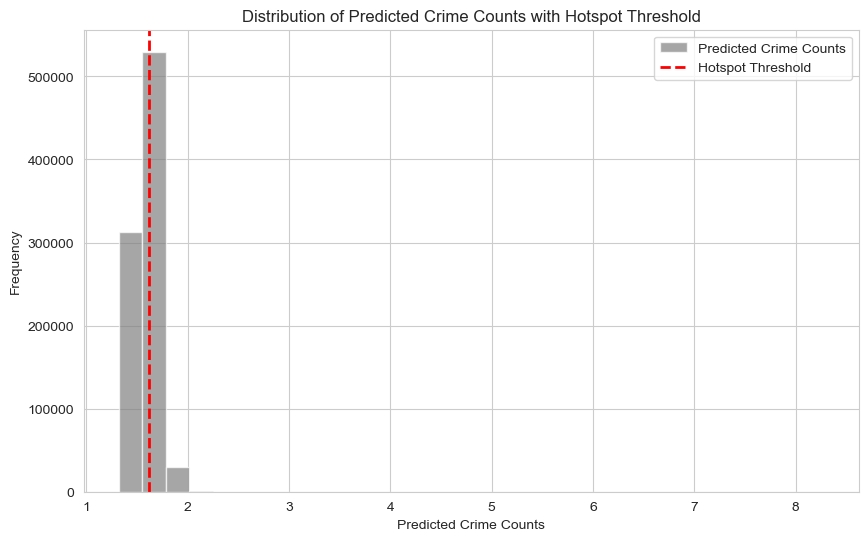

(218195, 1.6179932895697087)

In [8]:
# Determine a threshold for hotspots based on the top 25% of predicted crime counts
threshold = np.percentile(y_test_pred, 75)

# Identify hotspots based on this threshold
hotspots = test_agg_data[y_test_pred >= threshold]

# Visualization of hotspots
plt.figure(figsize=(10, 6))
plt.hist(y_test_pred, bins=30, color='grey', alpha=0.7, label='Predicted Crime Counts')
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=2, label='Hotspot Threshold')
plt.xlabel('Predicted Crime Counts')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Crime Counts with Hotspot Threshold')
plt.legend()
plt.show()

# Count of identified hotspots
len(hotspots), threshold


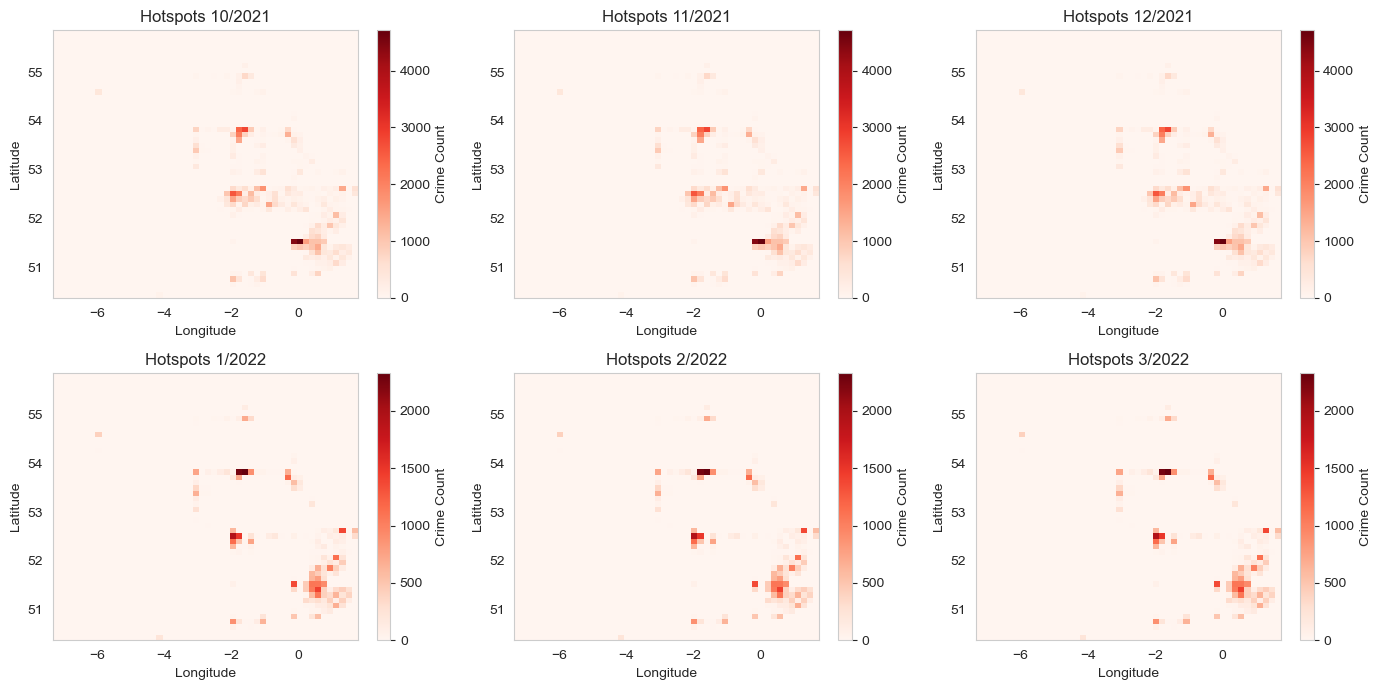

481803

In [9]:


# Use unique combinations of Latitude and Longitude from the test data as our spatial basis
unique_locations = test_agg_data[['Latitude', 'Longitude']].drop_duplicates()
# Extend the prediction period to 6 months (Oct 2021 to Mar 2022)
extended_prediction_months = [10, 11, 12, 1, 2, 3]
extended_prediction_years = [2021 if month > 9 else 2022 for month in extended_prediction_months]

# Create the prediction dataset for the extended period
extended_prediction_data = pd.concat(
    [unique_locations.assign(Month=month, Year=year) for month, year in zip(extended_prediction_months, extended_prediction_years)],
    ignore_index=True)

# Predict crime counts for these locations and extended months
extended_prediction_counts = gbm_model.predict(extended_prediction_data[['Year', 'Month', 'Latitude', 'Longitude']])

# Add the predicted counts to the dataset
extended_prediction_data['Predicted_Crime_Count'] = extended_prediction_counts

# Determine hotspots based on the previously established threshold for the extended period
extended_prediction_hotspots = extended_prediction_data[extended_prediction_data['Predicted_Crime_Count'] >= threshold]

# Visualization of predicted hotspots over the 6-month period
plt.figure(figsize=(14, 7))

# Plot each month as a separate subplot
for i, (month, year) in enumerate(zip(extended_prediction_months, extended_prediction_years), start=1):
    plt.subplot(2, 3, i)
    month_hotspots = extended_prediction_hotspots[(extended_prediction_hotspots['Month'] == month) & (extended_prediction_hotspots['Year'] == year)]
    plt.hist2d(month_hotspots['Longitude'], month_hotspots['Latitude'], bins=50, cmap='Reds')
    plt.colorbar().set_label('Crime Count')
    plt.title(f'Hotspots {month}/{year}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

plt.tight_layout()
plt.show()

len(extended_prediction_hotspots)


In [11]:
import folium
from folium.plugins import HeatMap
# Initialize a base map for the extended prediction period visualization
extended_base_map = folium.Map(location=[extended_prediction_hotspots['Latitude'].mean(), extended_prediction_hotspots['Longitude'].mean()], zoom_start=10)


sample_extended_hotspots = extended_prediction_hotspots

# Add a heat map layer for the sampled hotspots
HeatMap(data=sample_extended_hotspots[['Latitude', 'Longitude', 'Predicted_Crime_Count']].values.tolist(), radius=15, max_zoom=13).add_to(extended_base_map)

# Save the extended heatmap to an HTML file for viewing
extended_map_file_path = '/Users/duii/Desktop/crime_prevention_analysis/hotspots_map/6_mon_aggr_hotspot.html'
extended_base_map.save(extended_map_file_path)

extended_map_file_path


'/Users/duii/Desktop/crime_prevention_analysis/hotspots_map/6_mon_aggr_hotspot.html'

In [12]:
# Create individual maps for each of the 6 months to visualize hotspots per month
maps_for_each_month = {}

for month, year in zip(extended_prediction_months, extended_prediction_years):
    month_hotspots = extended_prediction_hotspots[(extended_prediction_hotspots['Month'] == month) & (extended_prediction_hotspots['Year'] == year)]
    # Initialize a base map for this specific month
    month_map = folium.Map(location=[month_hotspots['Latitude'].mean(), month_hotspots['Longitude'].mean()], zoom_start=10)
    # Add a heat map layer for the hotspots of this month
    HeatMap(data=month_hotspots[['Latitude', 'Longitude', 'Predicted_Crime_Count']].values.tolist(), radius=15, max_zoom=13).add_to(month_map)
    # Save the map to an HTML file
    map_file_path = f'/Users/duii/Desktop/crime_prevention_analysis/hotspots_map/hotspot_map_{year}_{month}.html'
    month_map.save(map_file_path)
    maps_for_each_month[f'{month}/{year}'] = map_file_path

maps_for_each_month

{'10/2021': '/Users/duii/Desktop/crime_prevention_analysis/hotspots_map/hotspot_map_2021_10.html',
 '11/2021': '/Users/duii/Desktop/crime_prevention_analysis/hotspots_map/hotspot_map_2021_11.html',
 '12/2021': '/Users/duii/Desktop/crime_prevention_analysis/hotspots_map/hotspot_map_2021_12.html',
 '1/2022': '/Users/duii/Desktop/crime_prevention_analysis/hotspots_map/hotspot_map_2022_1.html',
 '2/2022': '/Users/duii/Desktop/crime_prevention_analysis/hotspots_map/hotspot_map_2022_2.html',
 '3/2022': '/Users/duii/Desktop/crime_prevention_analysis/hotspots_map/hotspot_map_2022_3.html'}